In [109]:
# Check the working directory
import os
os.getcwd()

# Import all the necessary packages required for the session.
import pandas as pan
import numpy as np
import glob
import seaborn as sb
from matplotlib import pyplot as plt
import statistics as myStats
import scipy.stats as scipyStats
import textwrap
import random

pan.set_option('display.float_format', lambda x: '%.2f' % x)

In [220]:
# Define the necessary functions to be used throughout the program.

# Import the data files and concatenate them into one dataset.
def importData():
    year = '2014'
    dataFileList = []
    fileNames = [fileName for fileName in glob.glob(year + "/*.csv", recursive = True)]
    for fileName in fileNames:
        dataFileList.append(pan.read_csv(fileName))
        yearDataFile = pan.concat(dataFileList, ignore_index = False)
    print("Size of Dataset:", yearDataFile.shape)
    return yearDataFile

# Calculate total sales per day.
def calculateDailyTotalSales(dataFile):
    dataFile = dataFile.groupby(["Sale_Date"], as_index = True).agg({"Item_Value": "sum"}).rename(columns = {"Item_Value": "Daily_Total_Sale"})
    return dataFile

# Count the number of footfalls per day.
def calculateDailyFootfalls(dataFile):
    dataFile = dataFile.groupby(["Sale_Date"], as_index = True).agg({"UniSA_Receipt_No1": "nunique"}).rename(columns = {"UniSA_Receipt_No1": "Daily_Footfall_Count"})
    return dataFile

# Get distribution of sales per day.
def calculateDailySales(dataFile):
    dataFile = dataFile.groupby(["Sale_Date", "UniSA_Receipt_No1"], as_index = True).agg({"Item_Value": "sum"}).rename(columns = {"Item_Value": "Sale_Amount"})
    return dataFile

In [ ]:
# Import data for the year 2015
yearData = importData()

In [221]:
# Calculate the total sale for each day of the year.
aggregatedYearDataDailySale = calculateDailyTotalSales(yearData)

In [222]:
aggregatedYearDataDailySale["Daily_Total_Sale"] = pan.to_numeric(aggregatedYearDataDailySale["Daily_Total_Sale"]).round(2)
# Mean for the distribution
print("Mean Daily Total Sales: $" + str(round(myStats.mean(aggregatedYearDataDailySale["Daily_Total_Sale"]), 2)))
# Median for the distribution
print("Median Daily Total Sales: $" + str(round(myStats.median(aggregatedYearDataDailySale["Daily_Total_Sale"]), 2)))
# Standard Deviation for the distribution
print("Volatility Daily Total Sales: $" + str( round(myStats.stdev(aggregatedYearDataDailySale["Daily_Total_Sale"]), 2)))

# Calculating Risk Level for Daily Total Sales using Volatility:
print("Risk Level for Daily Sales: $" + str(round(myStats.median(aggregatedYearDataDailySale["Daily_Total_Sale"]) - myStats.stdev(aggregatedYearDataDailySale["Daily_Total_Sale"]), 2)))

# Calculating Value at Risk for Daily Total Sales at 5% significance level:
print("Value at Risk for Daily Sales at 95% confidence, one tailed: $" + str(round(aggregatedYearDataDailySale["Daily_Total_Sale"].quantile(.05), 2)))

Mean Daily Total Sales: $143939.15
Median Daily Total Sales: $141794.16
Volatility Daily Total Sales: $37416.6
Risk Level for Daily Sales: $104377.56
Value at Risk for Daily Sales at 95% confidence, one tailed: $85951.88


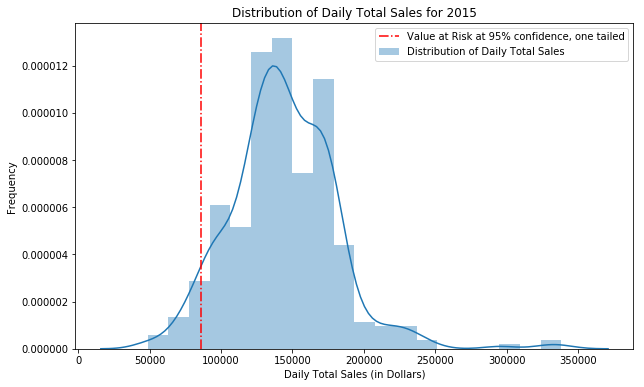

In [223]:
# Plot the distribution of Daily Total Sales for the year
plt.figure(figsize = (10, 6))
sb.distplot(aggregatedYearDataDailySale, label = "Distribution of Daily Total Sales", bins = 20, kde = True)
plt.axvline(round(aggregatedYearDataDailySale["Daily_Total_Sale"].quantile(.05), 2), color = "red", linestyle = "-.", label = "Value at Risk at 95% confidence, one tailed")
plt.xlabel("Daily Total Sales (in Dollars)")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Total Sales for 2015")
plt.legend()
plt.show()

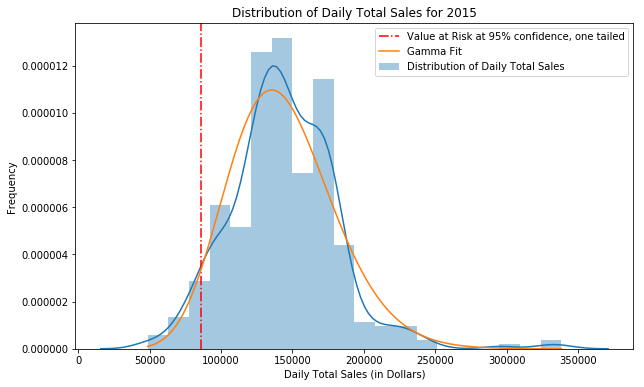

In [224]:
plt.figure(figsize = (10, 6))
histo = sb.distplot(aggregatedYearDataDailySale["Daily_Total_Sale"], label = "Distribution of Daily Total Sales", bins = 20, kde = True)
# plt.hist(aggregatedYearDataDailySale["Daily_Total_Sale"], bins = 10, density = True, color = "lightblue")
plt.axvline(round(aggregatedYearDataDailySale["Daily_Total_Sale"].quantile(.05), 2), color = "red", linestyle = "-.", label = "Value at Risk at 95% confidence, one tailed")
plt.xlabel("Daily Total Sales (in Dollars)")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Total Sales for 2015")
# Fitting a probability distribution ot the data.
xAxisTicks = plt.xticks()[0]
lineSpace = np.linspace(min(aggregatedYearDataDailySale["Daily_Total_Sale"]), max(aggregatedYearDataDailySale["Daily_Total_Sale"]), len(aggregatedYearDataDailySale["Daily_Total_Sale"]))
# fitAlpha, fitLoc, fitBeta = scipyStats.gamma.fit(aggregatedYearDataDailySale["Daily_Total_Sale"])
# gammaFit = scipyStats.gamma.pdf(lineSpace, fitAlpha, fitLoc, fitBeta)
fitAlpha, fitLoc, fitBeta = scipyStats.gamma.fit(aggregatedYearDataDailySale["Daily_Total_Sale"], loc = 0)
gammaFit = scipyStats.gamma.pdf(lineSpace, fitAlpha, fitLoc, fitBeta)
plt.plot(lineSpace, gammaFit, label = "Gamma Fit")
plt.legend()
plt.show()

In [225]:
# Estimate a new gamma distribution using the obtained values of
# alpha an beta.
gammaDist = scipyStats.gamma.rvs(fitAlpha, fitLoc, fitBeta, size = 362)
# Calculating Risk Level for Daily Total Sales using Volatility:
print("Risk Level for Daily Sales: $" + str(round(myStats.mean(gammaDist) - myStats.stdev(gammaDist), 2)))
# Calculating Value at Risk for Daily Total Sales at 5% significance level:
print("Estimated Gamma Distribution Value at Risk for Daily Sales at 95% confidence, one tailed: $" + str(round(pan.Series(logNormDist).quantile(0.05), 2)))

Risk Level for Daily Sales: $105438.38
Estimated Gamma Distribution Value at Risk for Daily Sales at 95% confidence, one tailed: $89692.95


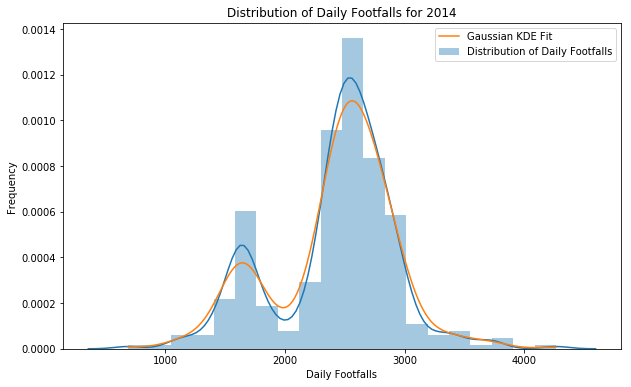

In [226]:
# Calculate the number of footfalls per day.
footfallsPerDay = calculateDailyFootfalls(yearData)
plt.figure(figsize = (10, 6))
histo = sb.distplot(footfallsPerDay["Daily_Footfall_Count"], label = "Distribution of Daily Footfalls", bins = 20, kde = True)
plt.xlabel("Daily Footfalls")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Footfalls for 2014")
xAxisTicks = plt.xticks()[0]
lineSpace = np.linspace(min(footfallsPerDay["Daily_Footfall_Count"]), max(footfallsPerDay["Daily_Footfall_Count"]), len(footfallsPerDay["Daily_Footfall_Count"]))

# Next, we try to fit a probability distribution on the data. Since this
# is a bimodal distribution, we using Kernal Density Estimation.
gaussianKDE = scipyStats.gaussian_kde(footfallsPerDay["Daily_Footfall_Count"])
plt.plot(lineSpace, gaussianKDE(lineSpace), label = "Gaussian KDE Fit")
plt.legend()
plt.show()

# Estimate the distribution of footfalls per day for 20 years.
footfallsPerDaySamples = gaussianKDE.resample(footfallsPerDay.shape[0] * 20).astype(int)

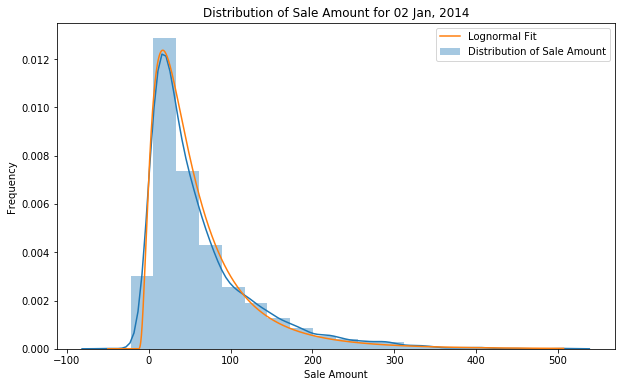

In [227]:
# Next, we look at the distribution of sales on random days:
dailySales = calculateDailySales(yearData[yearData["Sale_Date"] == "2014-01-02"])
plt.figure(figsize = (10, 6))
histo = sb.distplot(dailySales["Sale_Amount"], label = "Distribution of Sale Amount", bins = 20, kde = True)
plt.xlabel("Sale Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Sale Amount for 02 Jan, 2014")
lineSpace = np.linspace(min(dailySales["Sale_Amount"]), max(dailySales["Sale_Amount"]), len(dailySales["Sale_Amount"]))
fitShape, fitLoc, fitScale = scipyStats.lognorm.fit(dailySales["Sale_Amount"], loc = 0)
lognormalFit = scipyStats.lognorm.pdf(lineSpace, fitShape, fitLoc, fitScale)
plt.plot(lineSpace, lognormalFit, label = "Lognormal Fit")
plt.legend()
plt.show()

Risk Level for Daily Sales: $150827.37
Value at Risk for Daily Sales at 95% confidence, one tailed: $90754.55


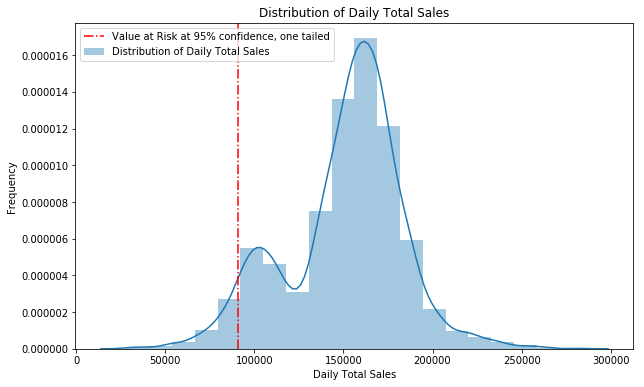

In [230]:
# Generate random samples of total sales for 20 years.
totalSalesSampled20Years = []
for singleDay in footfallsPerDaySamples[0]:
    singleDaySales = scipyStats.lognorm.rvs(fitShape, fitLoc, fitScale, size = singleDay).astype(int)
    totalSalesSampled20Years.append(sum(singleDaySales))

# Calculating Risk Level for Daily Total Sales using Volatility:
print("Risk Level for Daily Sales: $" + str(round(myStats.mean(totalSalesSampled20Years) - myStats.stdev(totalSalesSampled20Years), 2)))
# Calculating Value at Risk for Daily Total Sales at 5% significance level:
print("Value at Risk for Daily Sales at 95% confidence, one tailed: $" + str(round(np.percentile(np.array(totalSalesSampled20Years), 5), 2)))

plt.figure(figsize = (10, 6))
histo = sb.distplot(totalSalesSampled20Years, label = "Distribution of Daily Total Sales", bins = 20, kde = True)
plt.axvline(round(np.percentile(np.array(totalSalesSampled20Years), 5), 2), color = "red", linestyle = "-.", label = "Value at Risk at 95% confidence, one tailed")
plt.xlabel("Daily Total Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Total Sales")
plt.legend()
plt.show()